<a href="https://colab.research.google.com/github/desmond-rn/projet-inverse-2d/blob/master/src/notebook/Regression90x90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

L'objectif est de prédire la position et la hauteur d'un saut de densité (créneau) $\rho$, à partir de $E_l, E_d, E_r, E_u$ (energie des photons), $F_l, F_d, F_r, F_u$ (flux des photons), et $T_l, T_d, T_r, T_u$ (temperature du milieu) sur les bords du domaine en tout temps.

In [ ]:
%reset -f

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import keras
import random
import sklearn

from ast import literal_eval as l_eval

In [ ]:
from keras import layers
from keras import models
from keras import utils 
from keras import losses
from keras import metrics
from keras import optimizers
from keras import backend as K
from sklearn import metrics

In [ ]:
np.set_printoptions(precision = 3)

# PREPARATION

## Chargement des données

In [ ]:
""" DEPUIS GOOGLE DRIVE """

# from google.colab import drive
# drive.mount('/gdrive')

' DEPUIS GOOGLE DRIVE '

In [ ]:
%cd ~
%cd /gdrive/My\ Drive
%cd Colab\ Notebooks/Projet\ inverse/data/PQT
print()

%ls

/root
/gdrive/My Drive
/gdrive/My Drive/Colab Notebooks/Projet inverse/data/PQT

df_rho_part10.pqt  df_rho_part15.pqt  df_rho_part1.pqt   df_rho_part5.pqt
df_rho_part11.pqt  df_rho_part16.pqt  df_rho_part20.pqt  df_rho_part6.pqt
df_rho_part12.pqt  df_rho_part17.pqt  df_rho_part2.pqt   goodModel4/
df_rho_part13.pqt  df_rho_part18.pqt  df_rho_part3.pqt
df_rho_part14.pqt  df_rho_part19.pqt  df_rho_part4.pqt


Les donnees spatiales et temporelles (qui contiennent $\rho$, $E$, $F$, et $T$)

In [ ]:
""" Fonction pour concatener des dataframes"""

def join_dataframes(parts):
  df = pd.read_parquet("df_rho_"+parts[0]+".pqt")

  for part in parts[1:]:
    tmp = pd.read_parquet("df_rho_"+part+".pqt")  
    df = pd.concat([df, tmp], ignore_index=True)

  return df

- **PART 1**: la hauteur vaut 1, on a 9 positions [0.2, 0.5, 0.8] x [0.2, 0.5, 0.8] et 12 sources
 
- **PART 2**: la hauteur vaut 10, on a 9 positions [0.2, 0.5, 0.8] x [0.2, 0.5, 0.8] et 12 sources
- **PART 3**: la hauteur vaut 10, on a 16 positions [0.35, 0.45, 0.55, 0.65] x [0.35, 0.45, 0.55, 0.65] et 12 sources
- **PART 4**: la hauteur vaut 10, on a 4 positions [0.25, 0.75] x [0.25, 0.75] et 12 sources  
 
- **PART 5**: la hauteur vaut 4, on a 9 positions [0.35, 0.5, 0.65] x [0.35, 0.5, 0.65] et 12 sources

- **PART 6**: la hauteur vaut 7, on a 6 positions [0.2, 0.4] x [0.2, 0.4, 0.6, 0.8] et 12 sources



- **PART 10**: la hauteur vaut 10, on a 4 positions [0.3, 0.7] x [0.3, 0.7] et 4 sources
- **PART 11**: la hauteur vaut 10, on a 40 positions [0.200, 0.232] x [0.2 ... 0.8] et 4 sources
- **PART 12**: la hauteur vaut 10, on a 40 positions [0.263, 0.295] x [0.2 ... 0.8] et 4 sources
- **PART 13**: la hauteur vaut 10, on a 40 positions [0.326, 0.358] x [0.2 ... 0.8] et 4 sources
- **PART 14**: la hauteur vaut 10, on a 40 positions [0.389, 0.421] x [0.2 ... 0.8] et 4 sources
- **PART 15**: la hauteur vaut 10, on a 40 positions [0.453, 0.484] x [0.2 ... 0.8] et 4 sources
- **PART 16**: la hauteur vaut 10, on a 40 positions [0.516, 0.547] x [0.2 ... 0.8] et 4 sources
- **PART 17**: la hauteur vaut 10, on a 40 positions [0.579, 0.611] x [0.2 ... 0.8] et 4 sources
- **PART 18**: la hauteur vaut 10, on a 40 positions [0.642, 0.674] x [0.2 ... 0.8] et 4 sources
- **PART 19**: la hauteur vaut 10, on a 40 positions [0.705, 0.737] x [0.2 ... 0.8] et 4 sources
- **PART 20**: la hauteur vaut 10, on a 40 positions [0.768, 0.800] x [0.2 ... 0.8] et 4 sources
 



In [ ]:
df = join_dataframes(["part2", "part3", "part4"])

df.head(2)

,x_min,x_max,y_min,y_max,N,M,c,a,C_v,CFL,precision,t_0,t_f,step_count,rho_expr,sigma_a_expr,sigma_c_expr,E_0_expr,F_0_x_expr,F_0_y_expr,T_0_expr,E_u_expr,F_u_x_expr,F_u_y_expr,T_u_expr,E_d_expr,F_d_x_expr,F_d_y_expr,T_d_expr,E_l_expr,F_l_x_expr,F_l_y_expr,T_l_expr,E_r_expr,F_r_x_expr,F_r_y_expr,T_r_expr,rho_attr,rho,E_f,F_f_x,F_f_y,T_f,E_u,F_u,T_u,E_d,F_d,T_d,E_l,F_l,T_l,E_r,F_r,T_r
0,0,1,0,1,90,90,299,0.01372,0.14361,0.5,0.000001,0,0.0075,404,"crenau(0.2,0.2,0.1,10)",rho*T,rho*T,0.01372*(5^4),0,0,5,"ponctuel(0.1,0.3)",0,0,5,neumann,neumann,neumann,neumann,neumann,neumann,neumann,neumann,neumann,neumann,neumann,neumann,"[(0.2, 0.2, 0.1, 10)]","[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...","[[8.77704, 8.77174, 8.76643, 8.76113, 8.75587,...","[[0.012617, 0.0175062, 0.0219928, 0.0260363, 0...","[[-0.225149, -0.221526, -0.217552, -0.213162, ...","[[5.02509, 5.02711, 5.02352, 5.02556, 5.0219, ...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,..."
1,0,1,0,1,90,90,299,0.01372,0.14361,0.5,0.000001,0,0.0075,404,"crenau(0.2,0.2,0.1,10)",rho*T,rho*T,0.01372*(5^4),0,0,5,"ponctuel(0.3,0.5)",0,0,5,neumann,neumann,neumann,neumann,neumann,neumann,neumann,neumann,neumann,neumann,neumann,neumann,"[(0.2, 0.2, 0.1, 10)]","[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...","[[8.60722, 8.60694, 8.60675, 8.60667, 8.60673,...","[[0.00546114, 0.0055059, 0.00522933, 0.0046002...","[[-0.0639904, -0.0649036, -0.0655652, -0.06593...","[[4.99955, 4.99949, 4.99945, 4.99942, 4.99942,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,..."


In [ ]:
""" Dans les dataframes de 10 a 20, on a seulement 4 sources, ce qui necssite un traitement special """
parts = ["part"+str(i) for i in range(10, 21)]
print("la datafarme 'df_prime' contient:", parts)
print()

df_prime = join_dataframes(parts)

df_prime.head(2)

la datafarme 'df_prime' contient: ['part10', 'part11', 'part12', 'part13', 'part14', 'part15', 'part16', 'part17', 'part18', 'part19', 'part20']



,x_min,x_max,y_min,y_max,N,M,c,a,C_v,CFL,precision,t_0,t_f,step_count,rho_expr,sigma_a_expr,sigma_c_expr,E_0_expr,F_0_x_expr,F_0_y_expr,T_0_expr,E_u_expr,F_u_x_expr,F_u_y_expr,T_u_expr,E_d_expr,F_d_x_expr,F_d_y_expr,T_d_expr,E_l_expr,F_l_x_expr,F_l_y_expr,T_l_expr,E_r_expr,F_r_x_expr,F_r_y_expr,T_r_expr,rho_attr,rho,E_f,F_f_x,F_f_y,T_f,E_u,F_u,T_u,E_d,F_d,T_d,E_l,F_l,T_l,E_r,F_r,T_r
0,0,1,0,1,90,90,299,0.01372,0.14361,0.5,0.000001,0,0.0075,404,"crenau(0.3,0.3,0.1,10)",rho*T,rho*T,0.01372*(5^4),0,0,5,neumann,neumann,neumann,neumann,neumann,neumann,neumann,neumann,"ponctuel(0.1,0.3)",0,0,5,neumann,neumann,neumann,neumann,"[(0.3, 0.3, 0.1, 10)]","[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...","[[8.4166, 8.38137, 8.35782, 8.34563, 8.34445, ...","[[0.0291019, -0.0436691, -0.107023, -0.160469,...","[[-0.355759, -0.306624, -0.282705, -0.275475, ...","[[4.98095, 4.98006, 4.97682, 4.97534, 4.97081,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,..."
1,0,1,0,1,90,90,299,0.01372,0.14361,0.5,0.000001,0,0.0075,404,"crenau(0.3,0.3,0.1,10)",rho*T,rho*T,0.01372*(5^4),0,0,5,neumann,neumann,neumann,neumann,neumann,neumann,neumann,neumann,"ponctuel(0.3,0.5)",0,0,5,neumann,neumann,neumann,neumann,"[(0.3, 0.3, 0.1, 10)]","[[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1,...","[[8.69289, 8.71491, 8.73599, 8.75616, 8.77539,...","[[-0.0858279, -0.0759596, -0.0653819, -0.05417...","[[-0.104469, -0.13013, -0.151773, -0.169602, -...","[[5.01083, 5.01414, 5.01726, 5.02021, 5.02755,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,...","[[8.575, 8.575, 8.575, 8.575, 8.575, 8.575, 8....","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0,..."


Préréquis pour cet apprentissage. Toutes les données doivent etre similaires sur un certain nombre de leurs paramètres.

In [ ]:
t_f = 0.0075
x_min = 0
x_max = 1

for i in range(len(df)):
    assert df.loc[i, 't_f'] == t_f
    assert df.loc[i, 'E_0_expr'] == "0.01372*(5^4)"
    # etc...
    assert df.loc[i, 'x_min'] == x_min
    assert df.loc[i, 'x_max'] == x_max

## Visualisation

In [ ]:
""" Visualisons de la densite sur le domaine """

# pour placer les indices entre 1 et N
def set_ticks(ax):
  spacing = 20
  ax.set_xticks(np.arange(0, N, spacing))
  ax.set_xticklabels(np.arange(1, N+1, spacing))
  ax.set_yticks(np.arange(0, M, spacing))
  ax.set_yticklabels(np.arange(1, M+1, spacing))

def min_max(mat, dim=2):
  mat_min = mat
  for i in range(dim-1, -1, -1):
      mat_min = np.nanmin(mat_min, axis=i)
      
  mat_max = mat
  for i in range(dim-1, -1, -1):
      mat_max = np.nanmax(mat_max, axis=i)

  return mat_min, mat_max

def plot_output(ax, df, index, cmap="viridis"): 
  rho = np.stack(df.loc[index, 'rho'])
  rho_min, rho_max = min_max(rho)
  # print("rho:", (rho_min, rho_max))

  img = ax.imshow(rho, 
                  origin='lower', 
                  cmap=cmap, 
                  interpolation='none', 
                  aspect='auto', 
                  vmin=rho_min, vmax=rho_max, 
                  extent=[df.loc[index, "x_min"], df.loc[index, "x_max"], df.loc[index, "y_min"], df.loc[index, "y_max"]])
  ax.set_xlabel("x")
  ax.set_ylabel("y")
  ax.set_title("densité", size="x-large")

In [ ]:
""" Visualisons des signaux sur les bords du domaine """

def plot_input(ax, df, index, cmap="viridis", signal="E"):
    #  build the waves
    up = np.stack(df.loc[index, signal+"_u"])
    down = np.stack(df.loc[index, signal+"_d"])
    left = np.stack(df.loc[index, signal+"_l"])
    right = np.stack(df.loc[index, signal+"_r"])

    x_min = df.loc[index, "x_min"]
    x_max = df.loc[index, "x_max"]
    y_min = df.loc[index, "y_min"]
    y_max = df.loc[index, "y_max"]
    t_min = df.loc[index, "t_0"]
    t_max = df.loc[index, "t_f"]

    ax[0, 1].imshow(up, aspect='auto', origin="lower", cmap=cmap, extent=[x_min, x_max, t_min, t_max])
    ax[2, 1].imshow(down, aspect='auto', origin="lower", cmap=cmap, extent=[x_min, x_max, t_min, t_max])
    ax[1, 0].imshow(left.T, aspect='auto', origin="lower", cmap=cmap, extent=[t_min, t_max, y_min, y_max])
    ax[1, 2].imshow(right.T, aspect='auto', origin="lower", cmap=cmap, extent=[t_min, t_max, y_min, y_max])

    ax[1, 0].set_ylabel('y')
    ax[0, 2].set_ylabel('y')

    ax[0, 1].set_xlabel('x')
    ax[2, 1].set_xlabel('x')

    ax[0, 1].set_ylabel('t')
    ax[2, 1].set_ylabel('t')
    ax[1, 0].set_xlabel('t')
    ax[0, 2].set_xlabel('t')

    ax[0, 1].set_title(signal+' en haut',size="medium", y=0.99)
    ax[2, 1].set_title(signal+' en bas',size="medium", y=0.99)
    ax[1, 0].set_title(signal+' à gauche',size="medium", y=0.99)
    ax[1, 2].set_title(signal+' à droite',size="medium", y=0.99)

In [ ]:
def plot_io(ax, df, index, signal, cmap="viridis"):
  for i in range(3):
      for j in range(3):
          if (i == 1 or j == 1):
            ax[i, j].set_aspect("equal")
          else:
            ax[i, j].remove()

  plot_input(ax, df, index, signal=signal, cmap=cmap)
  plot_output(ax[1,1], df, index, cmap=cmap)

In [ ]:
def plot_all_sources(df, index_list, signal, base_fig_size, cmap="viridis"):
  fig,ax = plt.subplots(nrows=3, ncols=3*len(index_list), figsize=(base_fig_size[0]*len(index_list), base_fig_size[1]))

  for i, index in enumerate(index_list):
    if i%2 == 0:
      plot_io(ax[:, 3*i:3*(i+1)], df, index, signal=signal, cmap="viridis")
    else:
      plot_io(ax[:, 3*i:3*(i+1)], df, index, signal=signal, cmap="inferno")

  plt.suptitle("observation de rho et de "+signal+" pour les indices "+str(index_list), size="xx-large", y=1.02)
  plt.tight_layout();

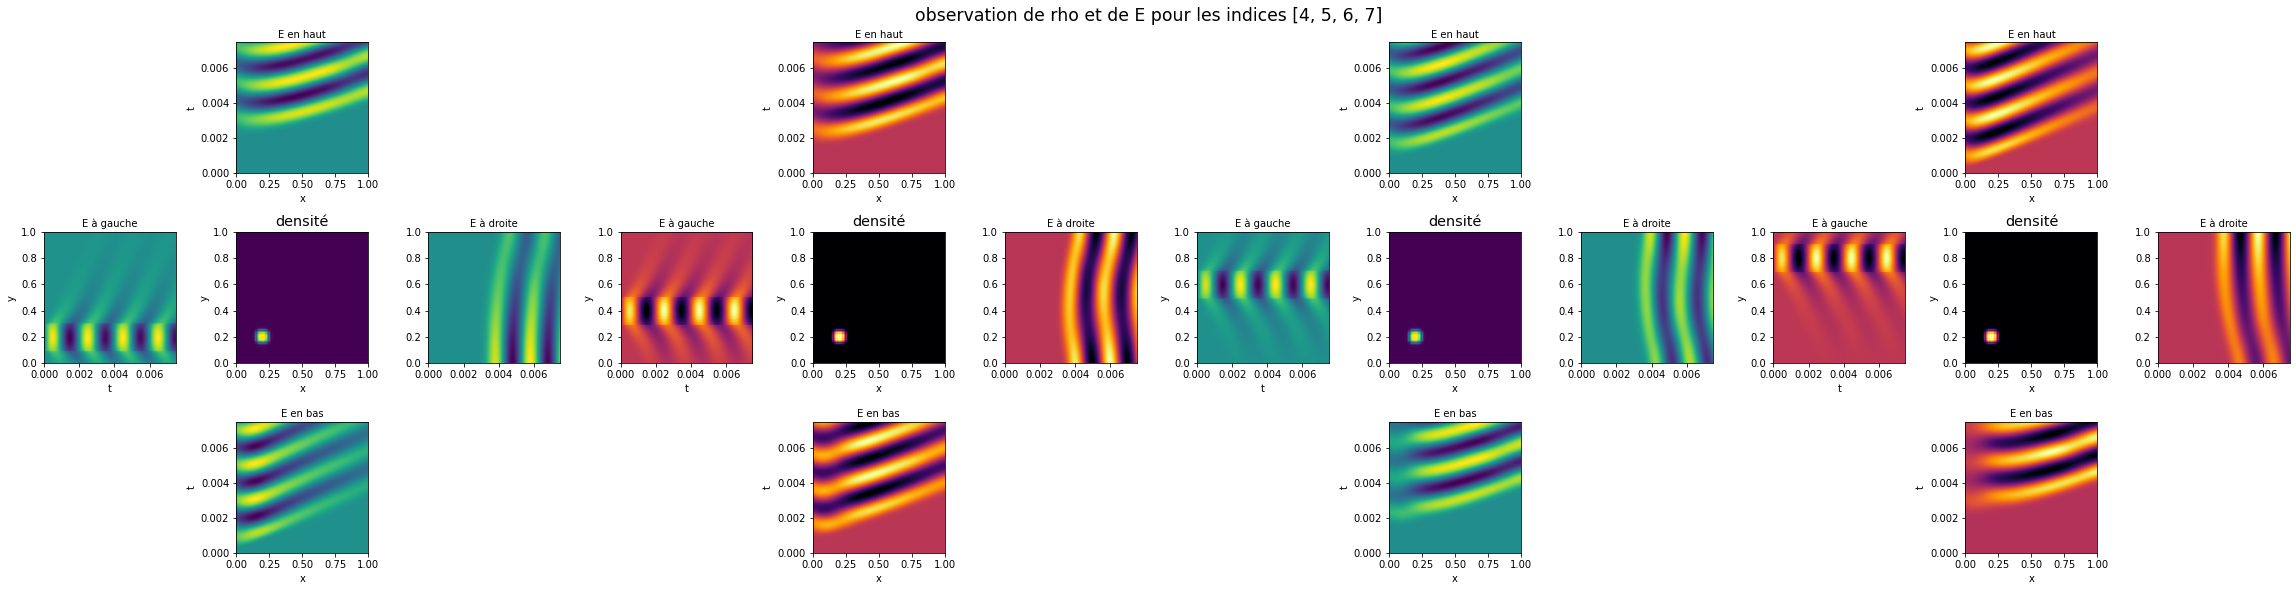

In [ ]:
plot_all_sources(df, index_list=[4, 5, 6, 7], signal="E", base_fig_size=(8, 8), cmap="viridis")

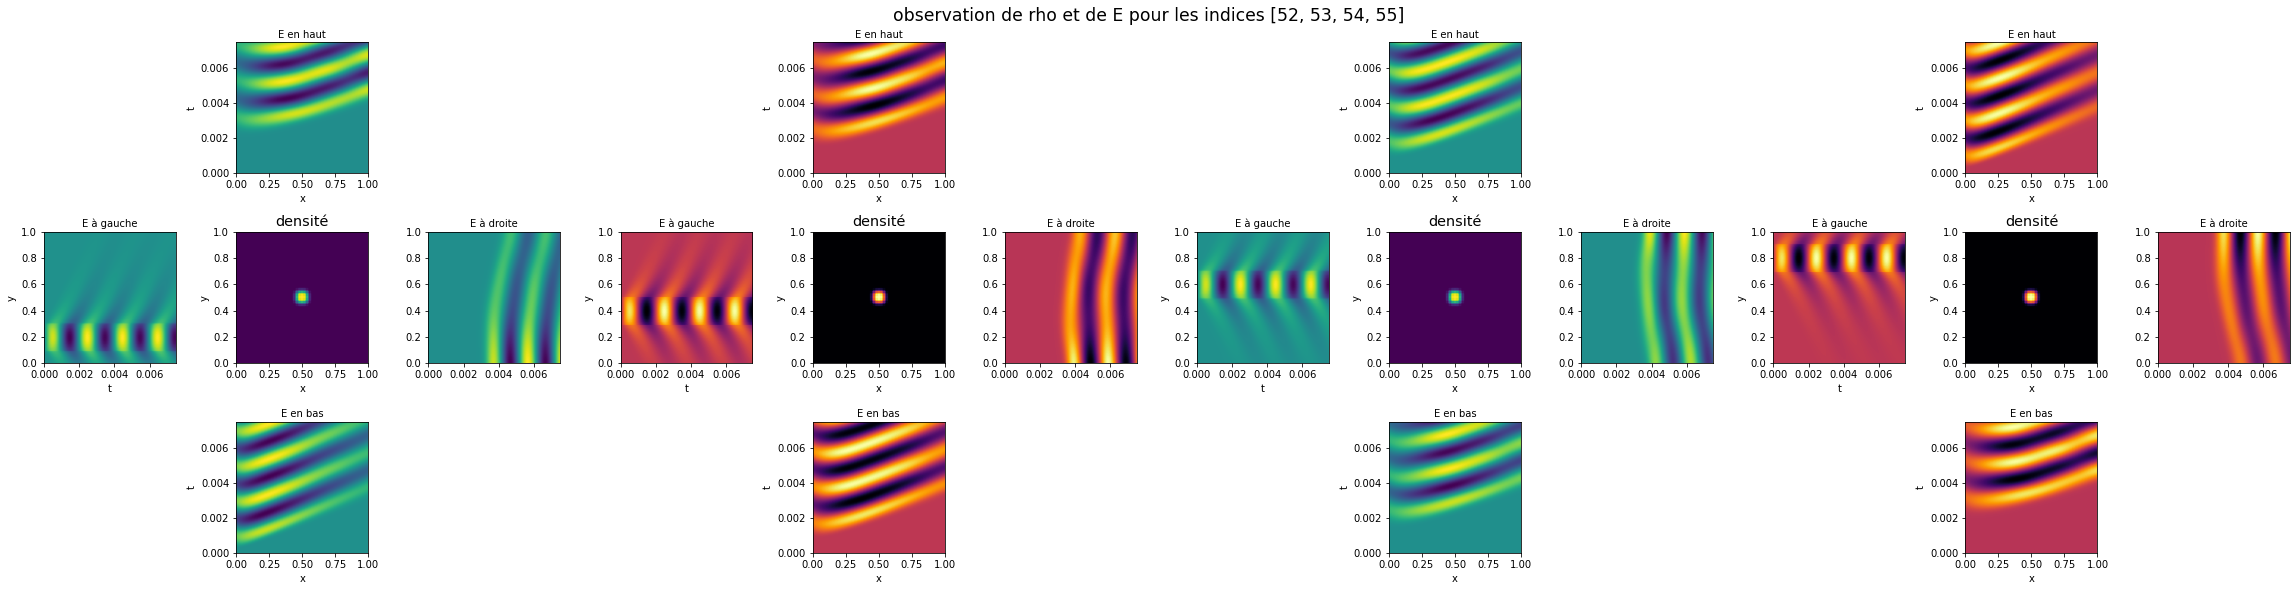

In [ ]:
plot_all_sources(df, index_list=[52, 53, 54, 55], signal="E", base_fig_size=(8, 8), cmap="viridis")

## Création des inputs X

Pour les dataframes de 1 a 6, il faut **12** simulations pour avoir un sample complet. Mais pour les dataframes de 10 a 20, il faut **4** simulations pour avoir un sample complet.

In [ ]:
def resample(input, shape_output):
  shape_input = input.shape
  output = np.empty(shape_output, dtype=float)
  step = shape_input[0]//shape_output[0]
  i = 0

  for j in np.arange(0, shape_output[0]):
    if i < shape_input[0]:
      output[j] = input[i]
    i += step

  return output

In [ ]:
# """ Generation les inputs X : 1er methode """
# """ On a 12 sources reparties sur 3 bords (haut, gauche et bas) et en entree du reseau de neuronnes le signal sur la droite"""
# n_sources = 12
# n_samples = len(df) // n_sources
# shape_X = (df.loc[0, "step_count"] // 10, df.loc[0, "N"])   # car N = M

# X = np.empty(shape=(n_samples, n_sources*shape_X[0], shape_X[1], 3), dtype=np.float32)

# for i in range(0, len(df), n_sources):
#   E = resample(np.stack(df.loc[i, 'E_r']), shape_X)
#   F = resample(np.stack(df.loc[i, 'F_r']), shape_X)
#   T = resample(np.stack(df.loc[i, 'T_r']), shape_X)

#   rho = df.loc[i, 'rho_expr']
#   for j in range(1, n_sources):
#     E = np.vstack([E, resample(np.stack(df.loc[i+j, 'E_r']), shape_X)])
#     F = np.vstack([F, resample(np.stack(df.loc[i+j, 'F_r']), shape_X)])
#     T = np.vstack([T, resample(np.stack(df.loc[i+j, 'T_r']), shape_X)])

#     assert rho == df.loc[i+j, 'rho_expr']

#   index = i // n_sources
#   X[index, :, :, 0] = E
#   X[index, :, :, 1] = F
#   X[index, :, :, 2] = T
    
# print("X shape =", X.shape)

In [ ]:
# """ Generation les inputs X: 2eme methode """ 
# """ Pour constrire les entrees X a partir de 'df'. Chaque sample correspond a 'n_sources' et les sources sur la gauche commencent a 'start'"""

# shape_X = (df.loc[0, "step_count"] // 15, df.loc[0, "N"])   # car N = M

# def make_data_X(df, n_sources, start):
#   n_samples = len(df) // n_sources
#   X = np.zeros(shape=(n_samples, 12*shape_X[0], shape_X[1], 3), dtype=np.float32)

#   index = 0
#   for i in range(0, len(df), n_sources):
#     E1 = resample(np.stack(df.loc[i+start, 'E_d']), shape_X)
#     E2 = resample(np.stack(df.loc[i+start, 'E_r']), shape_X)
#     E3 = resample(np.stack(df.loc[i+start, 'E_u']), shape_X)

#     F1 = resample(np.stack(df.loc[i+start, 'F_d']), shape_X)
#     F2 = resample(np.stack(df.loc[i+start, 'F_r']), shape_X)
#     F3 = resample(np.stack(df.loc[i+start, 'F_u']), shape_X)

#     T1 = resample(np.stack(df.loc[i+start, 'T_d']), shape_X)
#     T2 = resample(np.stack(df.loc[i+start, 'T_r']), shape_X)
#     T3 = resample(np.stack(df.loc[i+start, 'T_u']), shape_X)

#     rho = df.loc[i+start, 'rho_expr']
#     assert df.loc[i+start, 'E_l_expr'] != "neumann"
#     assert df.loc[i+start, 'E_d_expr'] == "neumann"
#     assert df.loc[i+start, 'E_r_expr'] == "neumann"
#     assert df.loc[i+start, 'E_u_expr'] == "neumann"

#     for j in range(start+1, start+4):
#       E1 = np.vstack([E1, resample(np.stack(df.loc[i+j, 'E_d']), shape_X)])
#       E2 = np.vstack([E2, resample(np.stack(df.loc[i+j, 'E_r']), shape_X)])
#       E3 = np.vstack([E3, resample(np.stack(df.loc[i+j, 'E_u']), shape_X)])

#       F1 = np.vstack([F1, resample(np.stack(df.loc[i+j, 'F_d']), shape_X)])
#       F2 = np.vstack([F2, resample(np.stack(df.loc[i+j, 'F_r']), shape_X)])
#       F3 = np.vstack([F3, resample(np.stack(df.loc[i+j, 'F_u']), shape_X)])

#       T1 = np.vstack([T1, resample(np.stack(df.loc[i+j, 'T_d']), shape_X)])
#       T2 = np.vstack([T2, resample(np.stack(df.loc[i+j, 'T_r']), shape_X)])
#       T3 = np.vstack([T3, resample(np.stack(df.loc[i+j, 'T_u']), shape_X)])

#       assert rho == df.loc[i+j, 'rho_expr']
#       assert df.loc[i+j, 'E_l_expr'] != "neumann"

#     X[index, :, :, 0] = np.vstack([E1, E2, E3])
#     X[index, :, :, 1] = np.vstack([F1, F2, F3])
#     X[index, :, :, 2] = np.vstack([T1, T2, T3])
#     index += 1

#   return X

In [ ]:
""" Generation les inputs X: 3eme methode """ 
""" On utilise les signaux sur les quatre bords """

resample_rate = 0.1     
time_size = int(df.loc[0, "step_count"] * resample_rate)     # On garde 10% des iterations (40 sur 404) 
space_size = df.loc[0, "N"]                             # On conserve tout l'espace (N = M = 90)
shape_X = (time_size, space_size)        # Taille d'un input X sans tenir compte des 4*4*3 canaux a suivre

def make_data_X(df, n_sources, start):
  n_samples = len(df) // n_sources
  X = np.zeros(shape=(n_samples, shape_X[0], shape_X[1], 4, 4, 3), dtype=np.float32)

  index = 0
  for i in range(0, len(df), n_sources):

    rho = df.loc[i+start, 'rho_expr']
    assert df.loc[i+start, 'E_l_expr'] != "neumann"
    assert df.loc[i+start, 'E_d_expr'] == "neumann"
    assert df.loc[i+start, 'E_r_expr'] == "neumann"
    assert df.loc[i+start, 'E_u_expr'] == "neumann"

    for j in range(start+0, start+4):

      for k, signal in enumerate(["E", "F", "T"]):
        X[index, :, :, 0, j-start, k] = resample(np.stack(df.loc[i+j, signal+'_l']), shape_X)
        X[index, :, :, 1, j-start, k] = resample(np.stack(df.loc[i+j, signal+'_d']), shape_X)
        X[index, :, :, 2, j-start, k] = resample(np.stack(df.loc[i+j, signal+'_r']), shape_X)
        X[index, :, :, 3, j-start, k] = resample(np.stack(df.loc[i+j, signal+'_u']), shape_X)

      assert rho == df.loc[i+j, 'rho_expr']
      assert df.loc[i+j, 'E_l_expr'] != "neumann"
      assert index == i//n_sources + i%n_sources

    index += 1

  return X

In [ ]:
""" On a seulement 4 sources (mais on fait comme si il y avait 12) et en entree du reseau de neuronnes le signal sur les 3 autres bords """
X = make_data_X(df, 12, 4)
# print("X shape =", X.shape)

In [ ]:
""" Sur les dataframes de 10 a 20, on a effectivement 4 sources ici, il n'ya pas de simulation inutile ici """
X_prime = make_data_X(df_prime, 4, 0)
# print("X_prime shape =", X_prime.shape)

## Creations des outputs y

In [ ]:
""" 2 eme methode, on a en realite 4 sources """
len_y = 2

def make_data_y(df, n_sources, start):
  n_targets = len(df) // n_sources
  y = np.zeros(shape=(n_targets, len_y), dtype=np.float32)

  index = 0
  for i in range(0, len(df), n_sources):

    attr = df.loc[i+start, 'rho_attr']
    for j in range(start+1, start+4):
      assert attr == df.loc[i+j, 'rho_attr']
    attr = l_eval(attr)[0]

    # y[index] = [attr[0], attr[1], attr[3]]
    y[index] = [attr[0], attr[1]]
    # y[index] = [attr[0]]

    index += 1

  return y

In [ ]:
""" 1er partie du jeu des donnees y: 12 sources """
y = make_data_y(df, 12, 4)

In [ ]:
""" 2eme partie du jeu des donnees y: 4 sources """
y_prime = make_data_y(df_prime, 4, 0)
# print("y shape =", y_prime.shape)

## Combinaison des jeux de donnees

Pour finir, on combine les deux jeux de donnees pour effectivement former X et y

In [ ]:
""" Liberation de la RAM avant de continuer """
del df
del df_prime

In [ ]:
""" A la fin, on combine les deux """
X = np.vstack([X_prime, X])

In [ ]:
""" On fait une simple normalisation des donnnees. Division par le maximum de valeur absolue de X """
""" 1er et 2eme aproche """
# min_E, max_E = min_max(np.abs(X[:, :, :, 0]), 3)
# min_F, max_F = min_max(np.abs(X[:, :, :, 1]), 3)
# min_T, max_T = min_max(np.abs(X[:, :, :, 2]), 3)

# X[:, :, :, 0] = X[:, :, :, 0] / max_E
# X[:, :, :, 1] = X[:, :, :, 1] / max_F
# X[:, :, :, 2] = X[:, :, :, 2] / max_T

""" 3eme approche """
min_E, max_E = min_max(np.abs(X[:, :, :, :, :, 0]), 3)
min_F, max_F = min_max(np.abs(X[:, :, :, :, :, 1]), 3)
min_T, max_T = min_max(np.abs(X[:, :, :, :, :, 2]), 3)

X[:, :, :, :, :, 0] = X[:, :, :, :, :, 0] / max_E
X[:, :, :, :, :, 1] = X[:, :, :, :, :, 1] / max_F
X[:, :, :, :, :, 2] = X[:, :, :, :, :, 2] / max_T

In [ ]:
""" On reshape X sous la forme (time_size, space_size, 4*4*3) """
X = X.reshape((len(X), shape_X[0], shape_X[1], 4*4*3))

In [ ]:
n_samples = len(X)
print("X shape =", X.shape)

X shape = (433, 40, 90, 48)


In [ ]:
""" verifier qu'aucun des X n'est completement null """
for i in range(n_samples):
  assert np.all(X[i] == 0) == False

In [ ]:
""" A la fin, on combine les deux """
y = np.vstack([y_prime, y])

In [ ]:
n_targets = len(y)
print("y shape =", y.shape)

y shape = (433, 2)


## Séparation des données train, test et val

In [ ]:
""" On fait une permutation des entrees et sorties """
shuffle = np.arange(n_samples)
random.shuffle(shuffle)

X_copy = X.copy()
y_copy = y.copy()

for i in range(n_samples):
  X_copy[i] = X[shuffle[i]]
  y_copy[i] = y[shuffle[i]]

X = X_copy
y = y_copy

In [ ]:
len_train, len_val = 7*len(X)//10, 2*len(X)//10

X_train = X[:len_train]
X_val = X[len_train:len_train+len_val]
X_test = X[len_train+len_val:]

y_train = y[:len_train]
y_val = y[len_train:len_train+len_val]
y_test = y[len_train+len_val:]

print("X shapes =", np.shape(X_train), np.shape(X_val), np.shape(X_test))
print("y shapes =", np.shape(y_train), np.shape(y_val), np.shape(y_test))

X shapes = (303, 40, 90, 48) (86, 40, 90, 48) (44, 40, 90, 48)
y shapes = (303, 2) (86, 2) (44, 2)


In [ ]:
# """ Sauvegarde de ce jeu de donnees pour un prochain apprentissage """

# np.save("dataset2_samples.npy", X)
# np.save("dataset2_labels.npy", y)

# APPRENTISSAGE

## Configuration du modèle 

In [ ]:
""" Un modèle convolutif """
model = models.Sequential(name="Convoluted_DRNN")

kernel_size = (3, 6)
strides = (1, 1)

model.add(layers.Conv2D(64, kernel_size, strides=strides, activation='relu', input_shape=(shape_X[0], shape_X[1], 4*4*3)))
model.add(layers.Conv2D(32, kernel_size, strides=strides, activation='relu'))

model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(64, kernel_size, strides=strides, activation='relu'))
model.add(layers.Conv2D(64, kernel_size, strides=strides, activation='relu'))

model.add(layers.MaxPooling2D())

model.add(layers.Conv2D(128, kernel_size, strides=strides, activation='relu'))
model.add(layers.Conv2D(128, kernel_size, strides=strides, activation='relu'))

model.add(layers.Flatten())

model.add(layers.Dense(500, activation='relu', activity_regularizer=keras.regularizers.l2(1e-5)))
# model.add(layers.Dense(500, activation='relu'))

model.add(layers.Dense(50, activation='relu', activity_regularizer=keras.regularizers.l2(1e-5)))
# model.add(layers.Dense(50, activation='relu'))

model.add(layers.Dense(len_y, activation='linear'))

model.summary()

Model: "Convoluted_DRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 38, 85, 64)        55360     
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 36, 80, 32)        36896     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 18, 40, 32)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 16, 35, 64)        36928     
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 14, 30, 64)        73792     
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 7, 15, 64)         0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 5, 10, 128)    

Pour la compilation:
- on utlise l'optimiseur Adam
- on utlise la `mse` pour fonction loss
- on observe le score r2

In [ ]:
""" Pour calculer le score r^2"""
def r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true - y_pred )) 
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(1e-5), 
              loss=keras.losses.mse,
              # metrics=[keras.metrics.mean_absolute_error]
              # metrics=[keras.metrics.mean_absolute_percentage_error]
              # metrics=[keras.metrics.cosine_proximity]
              metrics=[r2_score]
              )

In [ ]:
""" Pour une decroissance du taux d'apprentissage """
def scheduler(epoch, lr):
  if epoch == 0:
    return 0.001
  else:
    return 0.8 * lr

callback = keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
# history = model.fit(X_train,
#                     y_train,
#                     epochs=20,
#                     batch_size=len(X_train)//5+1,
#                     # callbacks=[callback],
#                     validation_data=(X_val, y_val))

In [ ]:
""" Technique d'aumentation du batch size """

def fit_increase(batch_sizes):
  for i, bs in enumerate(batch_sizes):
    print("STEP "+str(i), "/ 4", "- BATCH SIZE =", bs)
    global history
    history = model.fit(X_train,
                        y_train,
                        # epochs=int(5*(i+1)),
                        epochs=15,
                        batch_size=bs,
                        # callbacks=[callback],
                        validation_data=(X_val, y_val))
    print()

bbs = len(X_train) // 100  # base batch size (smallest)
fit_increase([bbs*1, bbs*5, bbs*10, bbs*20])

STEP 0 / 4 - BATCH SIZE = 3
Epoch 1/15
101/101 [==============================] - 2s 17ms/step - loss: 0.0496 - r2_score: -0.9078 - val_loss: 0.0311 - val_r2_score: -0.2474
Epoch 2/15
101/101 [==============================] - 1s 14ms/step - loss: 0.0331 - r2_score: -0.3651 - val_loss: 0.0333 - val_r2_score: -0.3648
Epoch 3/15
101/101 [==============================] - 1s 14ms/step - loss: 0.0321 - r2_score: -0.2153 - val_loss: 0.0308 - val_r2_score: -0.2039
Epoch 4/15
101/101 [==============================] - 1s 14ms/step - loss: 0.0314 - r2_score: -0.2725 - val_loss: 0.0280 - val_r2_score: -0.1079
Epoch 5/15
101/101 [==============================] - 1s 14ms/step - loss: 0.0296 - r2_score: -0.0738 - val_loss: 0.0330 - val_r2_score: -0.4324
Epoch 6/15
101/101 [==============================] - 1s 14ms/step - loss: 0.0295 - r2_score: -0.2769 - val_loss: 0.0265 - val_r2_score: -0.0692
Epoch 7/15
101/101 [==============================] - 1s 14ms/step - loss: 0.0273 - r2_score: -0.2049 

Verifions le taux d'apprentissage final.

In [ ]:
# """ devrait donner 0.002 * 0.95^(n_epoch-1) """
# round(model.optimizer.lr.numpy(), 5)

Observons la decroissance de la loss

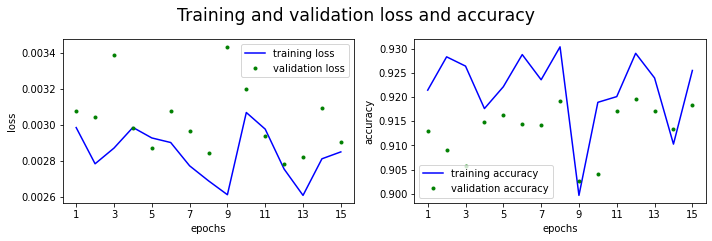

In [ ]:
history_dict = history.history

loss = history.history['loss']
val_loss = history.history['val_loss']
# acc = history_dict['cosine_proximity']
# val_acc = history_dict['val_cosine_proximity']
acc = history_dict['r2_score']
val_acc = history_dict['val_r2_score']

epochs = range(1, len(loss)+1)
ticks = range(1, len(loss)+1, 2)

fig,(ax0,ax1)=plt.subplots(1,2,figsize=(10, 3))

ax0.plot(epochs, loss, 'b', label='training loss')
ax0.plot(epochs, val_loss, 'g.', label='validation loss')
ax0.set_xticks(ticks)
ax0.set_xlabel('epochs')
ax0.set_ylabel('loss')
ax0.legend();

ax1.plot(epochs, acc, 'b', label='training accuracy')
ax1.plot(epochs, val_acc, 'g.', label='validation accuracy')
ax1.set_xticks(ticks)
ax1.set_xlabel('epochs')
ax1.set_ylabel('accuracy')
ax1.legend();

plt.suptitle("Training and validation loss and accuracy", y=1.1, fontsize='xx-large')
plt.tight_layout()

In [ ]:
# """ Sauvegardons les bons modeles qu'on obtient """

# model.save('goodModel4')

## Quelques predictions

In [ ]:
hat_y_test = model.predict(X_test)

In [ ]:
print("min max pour les prediction:", min_max(hat_y_test, 1)[0], min_max(hat_y_test, 1)[1])

min max pour les prediction: [0.21  0.255] [0.753 0.764]


In [ ]:
def print_prediction(hat_y_test, nb):
  start = len_train + len_val    #indique le debut des donnees test dans la dataframe
  for i in range(0, n_targets-start, (n_targets-start)//nb):
    print("target:    ", y_test[i])
    print("prediction:", hat_y_test[i], "\n")

# print_prediction(hat_y_test, len(X_test))
print_prediction(hat_y_test, 20)

target:     [0.8   0.768]
prediction: [0.722 0.605] 

target:     [0.484 0.642]
prediction: [0.54  0.669] 

target:     [0.295 0.2  ]
prediction: [0.357 0.261] 

target:     [0.484 0.295]
prediction: [0.512 0.277] 

target:     [0.5 0.8]
prediction: [0.524 0.732] 

target:     [0.2   0.326]
prediction: [0.266 0.312] 

target:     [0.326 0.389]
prediction: [0.324 0.347] 

target:     [0.516 0.453]
prediction: [0.586 0.426] 

target:     [0.263 0.358]
prediction: [0.281 0.315] 

target:     [0.358 0.768]
prediction: [0.362 0.764] 

target:     [0.737 0.737]
prediction: [0.715 0.637] 

target:     [0.737 0.232]
prediction: [0.68  0.375] 

target:     [0.358 0.642]
prediction: [0.346 0.674] 

target:     [0.579 0.516]
prediction: [0.667 0.523] 

target:     [0.579 0.705]
prediction: [0.623 0.69 ] 

target:     [0.516 0.389]
prediction: [0.571 0.355] 

target:     [0.295 0.389]
prediction: [0.302 0.352] 

target:     [0.295 0.516]
prediction: [0.246 0.513] 

target:     [0.389 0.232]
predic

In [ ]:
""" Le score r2 d'apres Keras """

print("r2 score on predictions: %.2f"%(100*model.evaluate(X_test, y_test)[1]), "%")

2/2 [==============================] - 0s 8ms/step - loss: 0.0025 - r2_score: 0.9292
r2 score on predictions: 92.92 %


Deffinissons une mesure d'accuracy. 

On suppose la prediction correcte si elle est suffisament proche du label:
- au **dizième** près pour la position (suivant x ou y)
- à l'**unité** près pour la hauteur 

In [ ]:
""" Calculons l'accuracy """

condition1 = (abs(y_test[:, 0] - hat_y_test[:, 0]) <= .1)         # postition x
condition2 = (abs(y_test[:, 1] - hat_y_test[:, 1]) <= .1)         # postition y
# condition3 = (abs(y_test[:, 2] - hat_y_test[:, 2]) <= 1)          # hauteur

acc_pos_x = 100 * len(hat_y_test[condition1]) / len(hat_y_test)
acc_pos_y = 100 * len(hat_y_test[condition2]) / len(hat_y_test)
# acc_hgt = 100 * len(hat_y_test[condition3]) / len(hat_y_test)
# acc = 100 * len(hat_y_test[condition1 & condition2 & condition3]) / len(hat_y_test)

print("position x accuracy: %.2f"%acc_pos_x, "%")
print("position y accuracy: %.2f"%acc_pos_y, "%")

# print("height accuracy:     %.2f"%acc_hgt, "%")
# print()
# print("total accuracy:      %.2f"%acc, "%")

position x accuracy: 100.00 %
position y accuracy: 90.91 %


## Conclusion